In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks

from imblearn.pipeline import Pipeline

# 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 모델 평가 
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
                             auc, precision_recall_curve, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)

from sklearn.model_selection import learning_curve

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data/CVD_cleaned.csv')
data.head()


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


---

#### 1. Trial 21
- 지난 시간에 성능이 제일 좋았던 21번 모델을 대상으로 시작
- svm SMOTE 적용

In [3]:
# 성별 원핫인코딩
data = pd.get_dummies(data, columns=['Sex'])
sex_columns = ['Sex_Female', 'Sex_Male']
for column in sex_columns:
    data[column] = data[column].map({True: 1, False: 0})

# Yes, No -> 1, 0
binary_columns = ['Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 
                  'Depression', 'Arthritis', 'Smoking_History','Exercise']

# diabetes
diabetes_mapping = {
    'No': 0,
    'No, pre-diabetes or borderline diabetes': 0, 
    'Yes, but female told only during pregnancy': 1,
    'Yes': 1
}
data['Diabetes'] = data['Diabetes'].map(diabetes_mapping)

# Heart_Disease, Skin_Cancer, Other_Cancer, Depression, Arthritis, Smoking_History, Exercise
for column in binary_columns:
    data[column] = data[column].map({'Yes': 1, 'No': 0})

# General_Health, Checkup, Age_Category
general_health_mapping = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Very Good': 3,
    'Excellent': 4
}

data['General_Health'] = data['General_Health'].map(general_health_mapping)

checkup_mapping = {
    'Never': 0,
    '5 or more years ago': 0.5,
    'Within the past 5 years': 1,
    'Within the past 2 years': 3,
    'Within the past year': 4
    
}
data['Checkup'] = data['Checkup'].map(checkup_mapping)



age_category_mapping = {
    '18-24': 0,
    '25-29': 1,
    '30-34': 2,
    '35-39': 3,
    '40-44': 4,
    '45-49': 5,
    '50-54': 6,
    '55-59': 7,
    '60-64': 8,
    '65-69': 9,
    '70-74': 10,
    '75-79': 11,
    '80+': 12
}
data['Age_Category'] = data['Age_Category'].map(age_category_mapping)  
data['Age_Category'] = 2 * data['Age_Category']

In [4]:
health = data.copy()

drop_columns = ['Arthritis', 'FriedPotato_Consumption', 'Fruit_Consumption',
                'Green_Vegetables_Consumption', 'Smoking_History', 'Weight_(kg)']

health.drop(columns=drop_columns, axis=1, inplace=True)
health.head()

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Age_Category,Height_(cm),BMI,Alcohol_Consumption,Sex_Female,Sex_Male
0,0,3.0,0,0,0,0,0,0,20,150.0,14.54,0.0,1,0
1,3,4.0,0,1,0,0,0,1,20,165.0,28.29,0.0,1,0
2,3,4.0,1,0,0,0,0,1,16,163.0,33.47,4.0,1,0
3,0,4.0,1,1,0,0,0,1,22,180.0,28.73,0.0,0,1
4,2,4.0,0,0,0,0,0,0,24,191.0,24.37,0.0,0,1


In [5]:

X = health.drop('Heart_Disease', axis = 1)
y = health['Heart_Disease']


# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


# svm SMOTE
svm_params = {'C': 0.001, 'max_iter': 1000}
svsmote = SVMSMOTE(random_state=13, out_step=0.7,  svm_estimator=SVC(**svm_params), n_jobs=-1)
X_train_svm, y_train_svm = svsmote.fit_resample(X_train, y_train)

model = SVC(**svm_params)
model.fit(X_train_svm, y_train_svm)

SVC(C=0.001, max_iter=1000)

[LightGBM] [Info] Number of positive: 227106, number of negative: 227106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 454212, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
  model_names  accuracy  precision    recall        f1   roc_auc
0      lr_clf  0.834324   0.252690  0.536043  0.343469  0.698301
1      dt_clf  0.867252   0.203258  0.219864  0.211235  0.572029
2      rf_clf  0.904842   0.287091  0.119343  0.168600  0.546638
3    lgbm_clf  0.893704   0.296899  0.230076  0.259251  0.591076
4     xgb_clf  0.728400   0.195073  0.754706  0.310014  0.740396


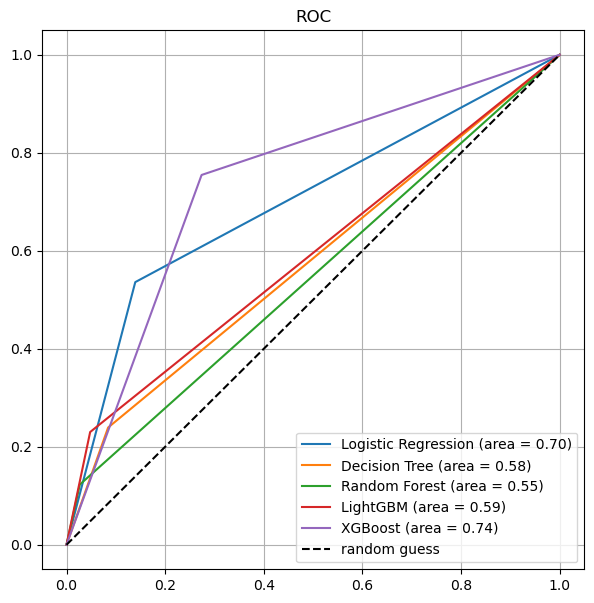

In [9]:

tmp = []

# LR
lr_clf = LogisticRegression(random_state=13, class_weight='balanced')
lr_clf.fit(X_train_svm, y_train_svm)
lr_pred_test = lr_clf.predict(X_test)

acc = accuracy_score(y_test, lr_pred_test)
pre = precision_score(y_test, lr_pred_test)
re = recall_score(y_test, lr_pred_test)
f1 = f1_score(y_test, lr_pred_test)
aucc = roc_auc_score(y_test, lr_pred_test)

# 결과 df로 저장
tmp.append(['lr_clf', acc, pre, re, f1, aucc])

# AUC
pred = lr_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr1, tpr1, thresholds = roc_curve(y_test, binary_pred)
roc_auc1 = auc(fpr1, tpr1)






####################################################################################################
# DT
dt_clf = DecisionTreeClassifier(random_state=13, class_weight='balanced')
dt_clf.fit(X_train_svm, y_train_svm)
dt_pred_test = dt_clf.predict(X_test)
# dt_pred_tr = dt_clf.predict(X_train_svm)

acc = accuracy_score(y_test, dt_pred_test)
pre = precision_score(y_test, dt_pred_test)
re = recall_score(y_test, dt_pred_test)
f1 = f1_score(y_test, dt_pred_test)
aucc = roc_auc_score(y_test, dt_pred_test)

tmp.append(['dt_clf', acc, pre, re, f1, aucc])

pred = dt_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr2, tpr2, thresholds = roc_curve(y_test, binary_pred)
roc_auc2 = auc(fpr2, tpr2)



###################################################################################################
# RF
rf_clf = RandomForestClassifier(random_state=13, class_weight='balanced')
rf_clf.fit(X_train_svm, y_train_svm)
rf_pred_test = rf_clf.predict(X_test)
# rf_pred_tr = rf_clf.predict(X_train_svm)

acc = accuracy_score(y_test, rf_pred_test)
pre = precision_score(y_test, rf_pred_test)
re = recall_score(y_test, rf_pred_test)
f1 = f1_score(y_test, rf_pred_test)
aucc = roc_auc_score(y_test, rf_pred_test)

tmp.append(['rf_clf', acc, pre, re, f1, aucc])

pred = rf_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr3, tpr3, thresholds = roc_curve(y_test, binary_pred)
roc_auc3 = auc(fpr3, tpr3)



#####################################################################################################
# LGBM
lgbm_clf = LGBMClassifier(random_state=13, class_weight='balanced')
lgbm_clf.fit(X_train_svm, y_train_svm)
lgbm_pred_test = lgbm_clf.predict(X_test)
# lgbm_pred_tr = lgbm_clf.predict(X_train_svm)

acc = accuracy_score(y_test, lgbm_pred_test)
pre = precision_score(y_test, lgbm_pred_test)
re = recall_score(y_test, lgbm_pred_test)
f1 = f1_score(y_test, lgbm_pred_test)
aucc = roc_auc_score(y_test, lgbm_pred_test)

tmp.append(['lgbm_clf', acc, pre, re, f1, aucc])

pred = lgbm_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr4, tpr4, thresholds = roc_curve(y_test, binary_pred)
roc_auc4 = auc(fpr4, tpr4)



########################################################################################################
# XGBoost
xgb_clf = XGBClassifier(random_sate=13, scale_pos_weight=10)

xgb_clf.fit(X_train_svm, y_train_svm)
xgb_pred_test = xgb_clf.predict(X_test)
# xgb_pred_tr = xgb_clf.predict(X_train_svm)


acc = accuracy_score(y_test, xgb_pred_test)
pre = precision_score(y_test, xgb_pred_test)
re = recall_score(y_test, xgb_pred_test)
f1 = f1_score(y_test, xgb_pred_test)
aucc = roc_auc_score(y_test, xgb_pred_test)

tmp.append(['xgb_clf', acc, pre, re, f1, aucc])

pred = xgb_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr5, tpr5, thresholds = roc_curve(y_test, binary_pred)
roc_auc5 = auc(fpr5, tpr5)





##########################################################################################################

col_names = ['model_names', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
df = pd.DataFrame(tmp, columns=col_names)
print(df)

plt.figure(figsize=(7, 7))

plt.plot(fpr1, tpr1, label='Logistic Regression (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Decision Tree (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Random Forest (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='LightGBM (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, label='XGBoost (area = %0.2f)' % roc_auc5)

plt.plot([0, 1], [0, 1], 'k--', label='random guess')
plt.title('ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [10]:
misclassified_index = [i for i in range(len(y_test)) if y_test.iloc[i] != xgb_pred_test[i]]

# 예측이 잘못된 데이터
misclassified_data = X_test.iloc[misclassified_index]
misclassified_data['y_true'] = y_test.iloc[misclassified_index]
misclassified_data['y_pred'] = xgb_pred_test[misclassified_index]
misclassified_data

,General_Health,Checkup,Exercise,Skin_Cancer,Other_Cancer,Depression,Diabetes,Age_Category,Height_(cm),BMI,Alcohol_Consumption,Sex_Female,Sex_Male,y_true,y_pred
73803,2,4.0,0,0,0,0,0,22,163.0,20.60,28.0,1,0,0,1
308010,1,4.0,1,0,1,0,0,14,170.0,24.28,0.0,1,0,0,1
72596,3,4.0,0,0,0,0,1,18,161.0,35.87,0.0,0,1,0,1
112805,2,4.0,1,0,0,0,0,16,170.0,39.16,2.0,0,1,0,1
128412,2,4.0,1,0,0,0,0,16,178.0,31.57,6.0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91041,0,4.0,1,0,0,1,0,12,173.0,52.91,3.0,1,0,0,1
8510,4,4.0,0,0,0,0,0,20,157.0,37.68,0.0,1,0,0,1
300301,2,4.0,0,0,1,0,0,22,157.0,27.07,0.0,1,0,0,1
198187,4,4.0,1,0,0,0,0,20,178.0,27.26,0.0,0,1,0,1


In [11]:
# 예측이 잘못된 데이터들의 values

for col in misclassified_data.columns:
    print("[{}]'s values : ".format(col) , misclassified_data[col].unique())

[General_Health]'s values :  [2 1 3 0 4]
[Checkup]'s values :  [4.  1.  3.  0.5 0. ]
[Exercise]'s values :  [0 1]
[Skin_Cancer]'s values :  [0 1]
[Other_Cancer]'s values :  [0 1]
[Depression]'s values :  [0 1]
[Diabetes]'s values :  [0 1]
[Age_Category]'s values :  [22 14 18 16 24 12  8  6 20 10  2  4  0]
[Height_(cm)]'s values :  [163. 170. 161. 178. 157. 175. 180. 165. 183. 185. 191. 145. 160. 173.
 172. 168. 188. 155. 152. 150. 193. 127. 142. 147. 196. 198. 174. 203.
 156.  91. 201. 140. 137. 135. 166. 226. 164. 176. 159. 162. 208. 158.
 132. 119. 105.]
[BMI]'s values :  [20.6  24.28 35.87 ... 52.46 41.21 52.91]
[Alcohol_Consumption]'s values :  [28.  0.  2.  6. 12.  1.  4.  8. 10. 16. 20. 30.  5.  3. 15. 25. 24.  7.
 23. 29. 21. 11. 14. 13. 22.  9. 27. 26. 18. 17.]
[Sex_Female]'s values :  [1 0]
[Sex_Male]'s values :  [0 1]
[y_true]'s values :  [0 1]
[y_pred]'s values :  [1 0]


- 혹시나 특정 value가 문제일까 확인했지만 특정할 수 없음. 이렇게만으로는 식별 불가

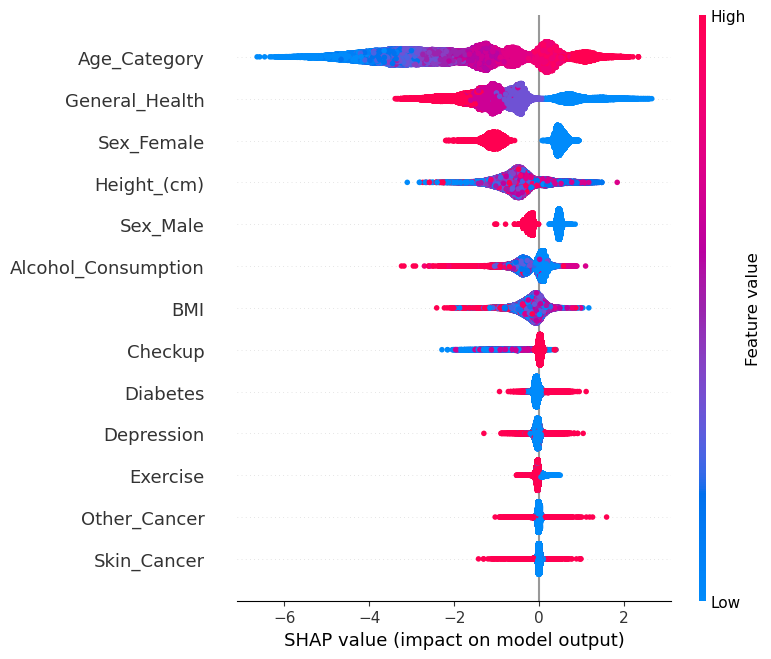

In [12]:
# shap을 이용해서 예측에 방해가 되는 feature 확인하기

import shap

explainer = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

# 특정 데이터 포인트에 대한 SHAP 값을 확인
shap.summary_plot(shap_values, X_test)

---

### 2. Age_Category를 삭제했을 때
- summary_plot에서 파란 영역이 가장 큰 컬럼인 Age_Category를 삭제했을 때, 성능이 향상되는가 확인

In [14]:
df = health.copy()

In [15]:
df.drop('Age_Category', axis=1, inplace=True)

In [16]:

X = df.drop('Heart_Disease', axis = 1)
y = df['Heart_Disease']


# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


# svm SMOTE
svm_params = {'C': 0.001, 'max_iter': 1000}
svsmote = SVMSMOTE(random_state=13, out_step=0.7,  svm_estimator=SVC(**svm_params), n_jobs=-1)
X_train_svm, y_train_svm = svsmote.fit_resample(X_train, y_train)

model = SVC(**svm_params)
model.fit(X_train_svm, y_train_svm)

SVC(C=0.001, max_iter=1000)

[LightGBM] [Info] Number of positive: 227106, number of negative: 227106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 984
[LightGBM] [Info] Number of data points in the train set: 454212, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
  model_names  accuracy  precision    recall        f1   roc_auc
0      lr_clf  0.835279   0.225554  0.426312  0.295018  0.648781
1      dt_clf  0.872594   0.183399  0.166800  0.174706  0.550737
2      rf_clf  0.895647   0.226038  0.119944  0.156724  0.541910
3    lgbm_clf  0.883214   0.233173  0.194233  0.211929  0.569024
4     xgb_clf  0.674297   0.157728  0.697837  0.257300  0.685032


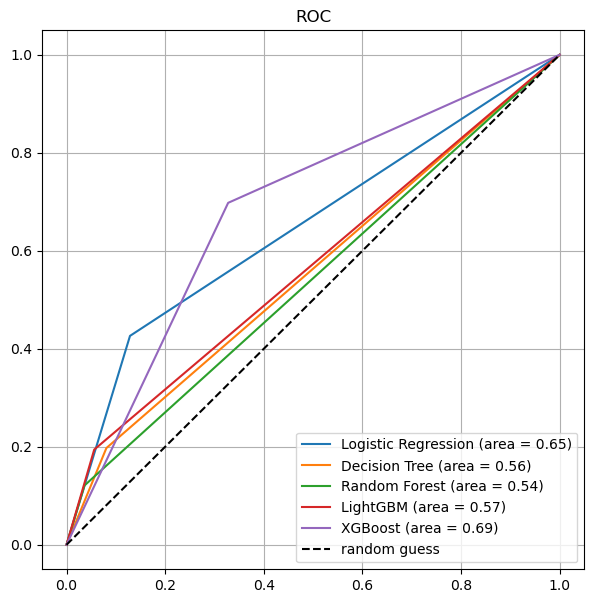

In [17]:
tmp = []

# LR
lr_clf = LogisticRegression(random_state=13, class_weight='balanced')
lr_clf.fit(X_train_svm, y_train_svm)
lr_pred_test = lr_clf.predict(X_test)

acc = accuracy_score(y_test, lr_pred_test)
pre = precision_score(y_test, lr_pred_test)
re = recall_score(y_test, lr_pred_test)
f1 = f1_score(y_test, lr_pred_test)
aucc = roc_auc_score(y_test, lr_pred_test)

# 결과 df로 저장
tmp.append(['lr_clf', acc, pre, re, f1, aucc])

# AUC
pred = lr_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr1, tpr1, thresholds = roc_curve(y_test, binary_pred)
roc_auc1 = auc(fpr1, tpr1)




####################################################################################################
# DT
dt_clf = DecisionTreeClassifier(random_state=13, class_weight='balanced')
dt_clf.fit(X_train_svm, y_train_svm)
dt_pred_test = dt_clf.predict(X_test)
# dt_pred_tr = dt_clf.predict(X_train_svm)

acc = accuracy_score(y_test, dt_pred_test)
pre = precision_score(y_test, dt_pred_test)
re = recall_score(y_test, dt_pred_test)
f1 = f1_score(y_test, dt_pred_test)
aucc = roc_auc_score(y_test, dt_pred_test)

tmp.append(['dt_clf', acc, pre, re, f1, aucc])

pred = dt_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr2, tpr2, thresholds = roc_curve(y_test, binary_pred)
roc_auc2 = auc(fpr2, tpr2)



###################################################################################################
# RF
rf_clf = RandomForestClassifier(random_state=13, class_weight='balanced')
rf_clf.fit(X_train_svm, y_train_svm)
rf_pred_test = rf_clf.predict(X_test)
# rf_pred_tr = rf_clf.predict(X_train_svm)

acc = accuracy_score(y_test, rf_pred_test)
pre = precision_score(y_test, rf_pred_test)
re = recall_score(y_test, rf_pred_test)
f1 = f1_score(y_test, rf_pred_test)
aucc = roc_auc_score(y_test, rf_pred_test)

tmp.append(['rf_clf', acc, pre, re, f1, aucc])

pred = rf_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr3, tpr3, thresholds = roc_curve(y_test, binary_pred)
roc_auc3 = auc(fpr3, tpr3)



#####################################################################################################
# LGBM
lgbm_clf = LGBMClassifier(random_state=13, class_weight='balanced')
lgbm_clf.fit(X_train_svm, y_train_svm)
lgbm_pred_test = lgbm_clf.predict(X_test)
# lgbm_pred_tr = lgbm_clf.predict(X_train_svm)

acc = accuracy_score(y_test, lgbm_pred_test)
pre = precision_score(y_test, lgbm_pred_test)
re = recall_score(y_test, lgbm_pred_test)
f1 = f1_score(y_test, lgbm_pred_test)
aucc = roc_auc_score(y_test, lgbm_pred_test)

tmp.append(['lgbm_clf', acc, pre, re, f1, aucc])

pred = lgbm_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr4, tpr4, thresholds = roc_curve(y_test, binary_pred)
roc_auc4 = auc(fpr4, tpr4)



########################################################################################################
# XGBoost
xgb_clf = XGBClassifier(random_sate=13, scale_pos_weight=10)

xgb_clf.fit(X_train_svm, y_train_svm)
xgb_pred_test = xgb_clf.predict(X_test)
# xgb_pred_tr = xgb_clf.predict(X_train_svm)


acc = accuracy_score(y_test, xgb_pred_test)
pre = precision_score(y_test, xgb_pred_test)
re = recall_score(y_test, xgb_pred_test)
f1 = f1_score(y_test, xgb_pred_test)
aucc = roc_auc_score(y_test, xgb_pred_test)

tmp.append(['xgb_clf', acc, pre, re, f1, aucc])

pred = xgb_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr5, tpr5, thresholds = roc_curve(y_test, binary_pred)
roc_auc5 = auc(fpr5, tpr5)





##########################################################################################################

col_names = ['model_names', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
df = pd.DataFrame(tmp, columns=col_names)
print(df)

plt.figure(figsize=(7, 7))

plt.plot(fpr1, tpr1, label='Logistic Regression (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Decision Tree (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Random Forest (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='LightGBM (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, label='XGBoost (area = %0.2f)' % roc_auc5)

plt.plot([0, 1], [0, 1], 'k--', label='random guess')
plt.title('ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

--> 성능이 오히려 더 떨어짐...

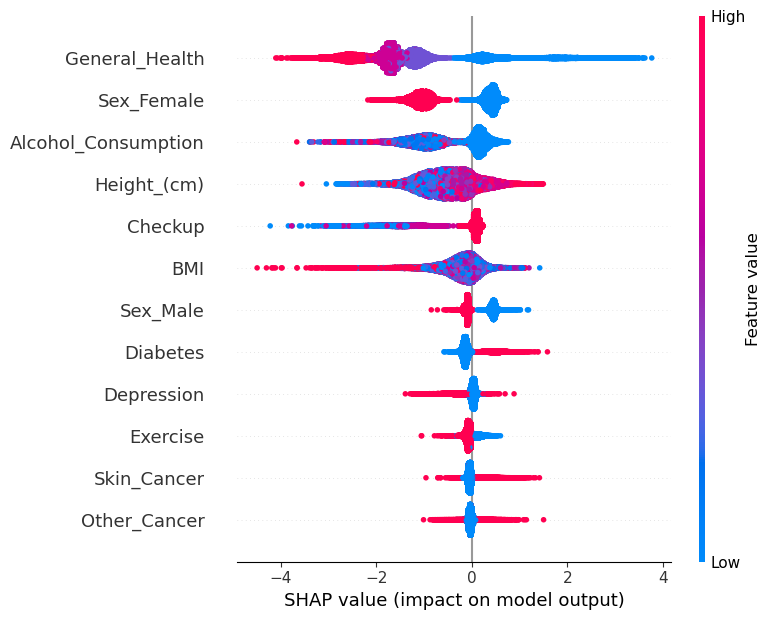

In [18]:

explainer = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

# 특정 데이터 포인트에 대한 SHAP 값을 확인
shap.summary_plot(shap_values, X_test)

--> 심지어 모델 성능을 방해하는 컬럼이 더 늘었음
아쉽게도 파란 영역의 데이터를 직접적으로 확인하는 방법을 찾지 못해서 'General_Health'까지 제거 해보기로 함.

---

### 3. 'General_Health' 삭제했을 경우
- 그렇다면 'General_Health'의 경우에도 삭제해도 성능이 올라가지는 않을지 확인

In [21]:
health_tmp = health.copy()
health_tmp.drop(['Age_Category', 'General_Health'], axis=1, inplace=True)
health_tmp.head(2)

,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Height_(cm),BMI,Alcohol_Consumption,Sex_Female,Sex_Male
0,3.0,0,0,0,0,0,0,150.0,14.54,0.0,1,0
1,4.0,0,1,0,0,0,1,165.0,28.29,0.0,1,0


In [23]:
X = health_tmp.drop('Heart_Disease', axis = 1)
y = health_tmp['Heart_Disease']


# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


# svm SMOTE
svm_params = {'C': 0.001, 'max_iter': 1000}
svsmote = SVMSMOTE(random_state=13, out_step=0.7,  svm_estimator=SVC(**svm_params), n_jobs=-1)
X_train_svm, y_train_svm = svsmote.fit_resample(X_train, y_train)

model = SVC(**svm_params)
model.fit(X_train_svm, y_train_svm)

SVC(C=0.001, max_iter=1000)

[LightGBM] [Info] Number of positive: 227106, number of negative: 227106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 827
[LightGBM] [Info] Number of data points in the train set: 454212, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
  model_names  accuracy  precision    recall        f1   roc_auc
0      lr_clf  0.796636   0.127045  0.258110  0.170277  0.551057
1      dt_clf  0.875071   0.154354  0.121746  0.136124  0.531539
2      rf_clf  0.888006   0.154454  0.086103  0.110568  0.522321
3    lgbm_clf  0.859918   0.082592  0.072487  0.077210  0.500833
4     xgb_clf  0.654093   0.142495  0.653384  0.233966  0.653770


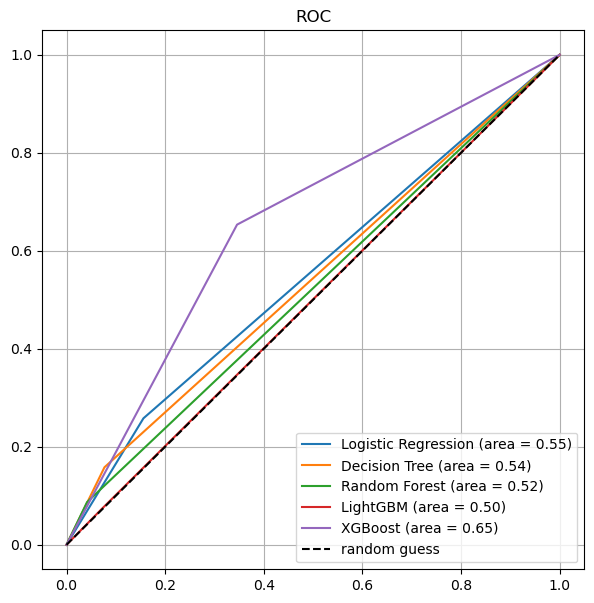

In [24]:
tmp = []

# LR
lr_clf = LogisticRegression(random_state=13, class_weight='balanced')
lr_clf.fit(X_train_svm, y_train_svm)
lr_pred_test = lr_clf.predict(X_test)

acc = accuracy_score(y_test, lr_pred_test)
pre = precision_score(y_test, lr_pred_test)
re = recall_score(y_test, lr_pred_test)
f1 = f1_score(y_test, lr_pred_test)
aucc = roc_auc_score(y_test, lr_pred_test)

# 결과 df로 저장
tmp.append(['lr_clf', acc, pre, re, f1, aucc])

# AUC
pred = lr_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr1, tpr1, thresholds = roc_curve(y_test, binary_pred)
roc_auc1 = auc(fpr1, tpr1)




####################################################################################################
# DT
dt_clf = DecisionTreeClassifier(random_state=13, class_weight='balanced')
dt_clf.fit(X_train_svm, y_train_svm)
dt_pred_test = dt_clf.predict(X_test)
# dt_pred_tr = dt_clf.predict(X_train_svm)

acc = accuracy_score(y_test, dt_pred_test)
pre = precision_score(y_test, dt_pred_test)
re = recall_score(y_test, dt_pred_test)
f1 = f1_score(y_test, dt_pred_test)
aucc = roc_auc_score(y_test, dt_pred_test)

tmp.append(['dt_clf', acc, pre, re, f1, aucc])

pred = dt_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr2, tpr2, thresholds = roc_curve(y_test, binary_pred)
roc_auc2 = auc(fpr2, tpr2)



###################################################################################################
# RF
rf_clf = RandomForestClassifier(random_state=13, class_weight='balanced')
rf_clf.fit(X_train_svm, y_train_svm)
rf_pred_test = rf_clf.predict(X_test)
# rf_pred_tr = rf_clf.predict(X_train_svm)

acc = accuracy_score(y_test, rf_pred_test)
pre = precision_score(y_test, rf_pred_test)
re = recall_score(y_test, rf_pred_test)
f1 = f1_score(y_test, rf_pred_test)
aucc = roc_auc_score(y_test, rf_pred_test)

tmp.append(['rf_clf', acc, pre, re, f1, aucc])

pred = rf_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr3, tpr3, thresholds = roc_curve(y_test, binary_pred)
roc_auc3 = auc(fpr3, tpr3)



#####################################################################################################
# LGBM
lgbm_clf = LGBMClassifier(random_state=13, class_weight='balanced')
lgbm_clf.fit(X_train_svm, y_train_svm)
lgbm_pred_test = lgbm_clf.predict(X_test)
# lgbm_pred_tr = lgbm_clf.predict(X_train_svm)

acc = accuracy_score(y_test, lgbm_pred_test)
pre = precision_score(y_test, lgbm_pred_test)
re = recall_score(y_test, lgbm_pred_test)
f1 = f1_score(y_test, lgbm_pred_test)
aucc = roc_auc_score(y_test, lgbm_pred_test)

tmp.append(['lgbm_clf', acc, pre, re, f1, aucc])

pred = lgbm_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr4, tpr4, thresholds = roc_curve(y_test, binary_pred)
roc_auc4 = auc(fpr4, tpr4)



########################################################################################################
# XGBoost
xgb_clf = XGBClassifier(random_sate=13, scale_pos_weight=10)

xgb_clf.fit(X_train_svm, y_train_svm)
xgb_pred_test = xgb_clf.predict(X_test)
# xgb_pred_tr = xgb_clf.predict(X_train_svm)


acc = accuracy_score(y_test, xgb_pred_test)
pre = precision_score(y_test, xgb_pred_test)
re = recall_score(y_test, xgb_pred_test)
f1 = f1_score(y_test, xgb_pred_test)
aucc = roc_auc_score(y_test, xgb_pred_test)

tmp.append(['xgb_clf', acc, pre, re, f1, aucc])

pred = xgb_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr5, tpr5, thresholds = roc_curve(y_test, binary_pred)
roc_auc5 = auc(fpr5, tpr5)





##########################################################################################################

col_names = ['model_names', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
df = pd.DataFrame(tmp, columns=col_names)
print(df)

plt.figure(figsize=(7, 7))

plt.plot(fpr1, tpr1, label='Logistic Regression (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Decision Tree (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Random Forest (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='LightGBM (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, label='XGBoost (area = %0.2f)' % roc_auc5)

plt.plot([0, 1], [0, 1], 'k--', label='random guess')
plt.title('ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

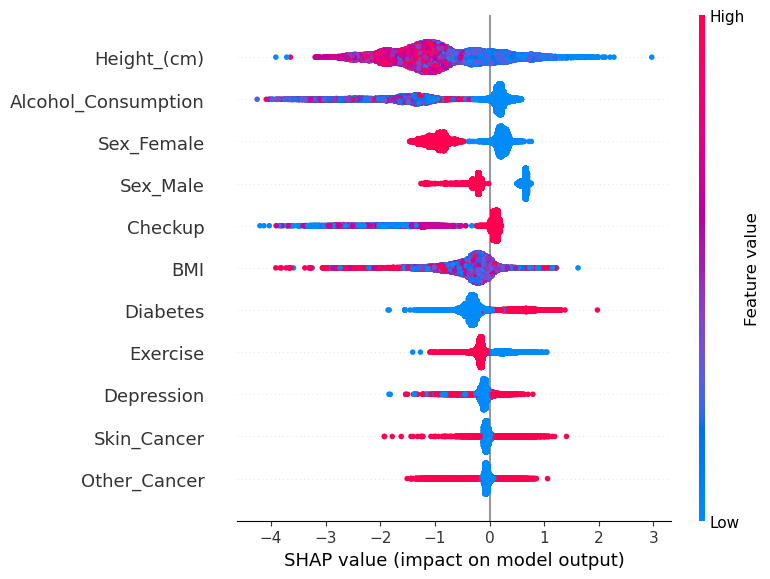

In [25]:
# shap을 이용해서 예측에 방해가 되는 feature 확인하기

import shap

explainer = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

# 특정 데이터 포인트에 대한 SHAP 값을 확인
shap.summary_plot(shap_values, X_test)

--> 점점 모델의 성능을 방해하는 feature들이 늘어감
<br></br>
사실 'Age_Category','General_Health'에 예측을 방해하는 파란 부분도 크지만, 예측에 기여하는 빨간 부분도 제일 크기도 함

---

### 4. 잘못 예측하는 데이터만 지웠을 때

- 혹시 잘못 예측하는 데이터들을 지워봤을 때 성능이 좋아지나 시험삼아 테스트

In [26]:
health.drop(misclassified_index, axis=0, inplace=True)
health

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Age_Category,Height_(cm),BMI,Alcohol_Consumption,Sex_Female,Sex_Male
0,0,3.0,0,0,0,0,0,0,20,150.0,14.54,0.0,1,0
1,3,4.0,0,1,0,0,0,1,20,165.0,28.29,0.0,1,0
2,3,4.0,1,0,0,0,0,1,16,163.0,33.47,4.0,1,0
3,0,4.0,1,1,0,0,0,1,22,180.0,28.73,0.0,0,1
4,2,4.0,0,0,0,0,0,0,24,191.0,24.37,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308849,3,4.0,1,0,0,0,0,0,2,168.0,29.05,4.0,0,1
308850,1,1.0,1,0,0,0,0,1,18,180.0,21.48,8.0,0,1
308851,3,0.5,1,0,0,0,1,1,4,157.0,24.69,4.0,1,0
308852,3,4.0,1,0,0,0,0,0,18,183.0,23.73,3.0,0,1


In [27]:

X = health.drop('Heart_Disease', axis = 1)
y = health['Heart_Disease']


# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


# svm SMOTE
svm_params = {'C': 0.001, 'max_iter': 1000}
svsmote = SVMSMOTE(random_state=13, out_step=0.7,  svm_estimator=SVC(**svm_params), n_jobs=-1)
X_train_svm, y_train_svm = svsmote.fit_resample(X_train, y_train)

model = SVC(**svm_params)
model.fit(X_train_svm, y_train_svm)

SVC(C=0.001, max_iter=1000)

[LightGBM] [Info] Number of positive: 214703, number of negative: 214703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 429406, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
  model_names  accuracy  precision    recall        f1   roc_auc
0      lr_clf  0.853413   0.244043  0.384680  0.298632  0.639738
1      dt_clf  0.866424   0.204589  0.223887  0.213804  0.573519
2      rf_clf  0.905214   0.295803  0.121967  0.172718  0.548166
3    lgbm_clf  0.897956   0.256961  0.136316  0.178133  0.550757
4     xgb_clf  0.726753   0.195705  0.761553  0.311389  0.742617


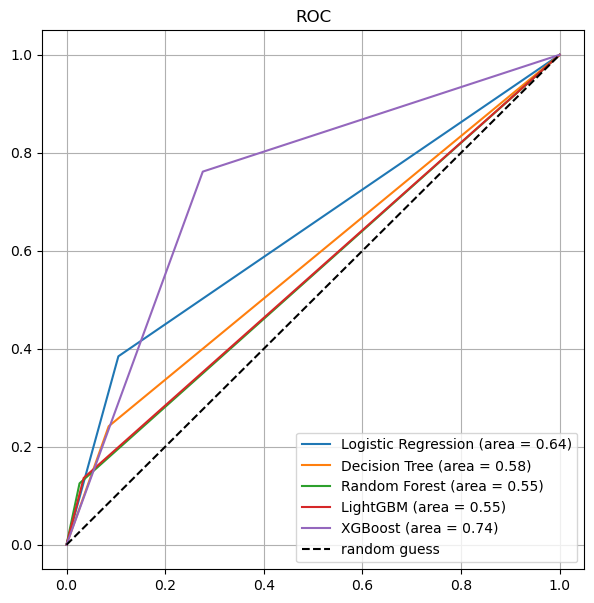

In [28]:
tmp = []

# LR
lr_clf = LogisticRegression(random_state=13, class_weight='balanced')
lr_clf.fit(X_train_svm, y_train_svm)
lr_pred_test = lr_clf.predict(X_test)

acc = accuracy_score(y_test, lr_pred_test)
pre = precision_score(y_test, lr_pred_test)
re = recall_score(y_test, lr_pred_test)
f1 = f1_score(y_test, lr_pred_test)
aucc = roc_auc_score(y_test, lr_pred_test)

# 결과 df로 저장
tmp.append(['lr_clf', acc, pre, re, f1, aucc])

# AUC
pred = lr_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr1, tpr1, thresholds = roc_curve(y_test, binary_pred)
roc_auc1 = auc(fpr1, tpr1)






####################################################################################################
# DT
dt_clf = DecisionTreeClassifier(random_state=13, class_weight='balanced')
dt_clf.fit(X_train_svm, y_train_svm)
dt_pred_test = dt_clf.predict(X_test)
# dt_pred_tr = dt_clf.predict(X_train_svm)

acc = accuracy_score(y_test, dt_pred_test)
pre = precision_score(y_test, dt_pred_test)
re = recall_score(y_test, dt_pred_test)
f1 = f1_score(y_test, dt_pred_test)
aucc = roc_auc_score(y_test, dt_pred_test)

tmp.append(['dt_clf', acc, pre, re, f1, aucc])

pred = dt_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr2, tpr2, thresholds = roc_curve(y_test, binary_pred)
roc_auc2 = auc(fpr2, tpr2)



###################################################################################################
# RF
rf_clf = RandomForestClassifier(random_state=13, class_weight='balanced')
rf_clf.fit(X_train_svm, y_train_svm)
rf_pred_test = rf_clf.predict(X_test)
# rf_pred_tr = rf_clf.predict(X_train_svm)

acc = accuracy_score(y_test, rf_pred_test)
pre = precision_score(y_test, rf_pred_test)
re = recall_score(y_test, rf_pred_test)
f1 = f1_score(y_test, rf_pred_test)
aucc = roc_auc_score(y_test, rf_pred_test)

tmp.append(['rf_clf', acc, pre, re, f1, aucc])

pred = rf_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr3, tpr3, thresholds = roc_curve(y_test, binary_pred)
roc_auc3 = auc(fpr3, tpr3)



#####################################################################################################
# LGBM
lgbm_clf = LGBMClassifier(random_state=13, class_weight='balanced')
lgbm_clf.fit(X_train_svm, y_train_svm)
lgbm_pred_test = lgbm_clf.predict(X_test)
# lgbm_pred_tr = lgbm_clf.predict(X_train_svm)

acc = accuracy_score(y_test, lgbm_pred_test)
pre = precision_score(y_test, lgbm_pred_test)
re = recall_score(y_test, lgbm_pred_test)
f1 = f1_score(y_test, lgbm_pred_test)
aucc = roc_auc_score(y_test, lgbm_pred_test)

tmp.append(['lgbm_clf', acc, pre, re, f1, aucc])

pred = lgbm_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr4, tpr4, thresholds = roc_curve(y_test, binary_pred)
roc_auc4 = auc(fpr4, tpr4)



########################################################################################################
# XGBoost
xgb_clf = XGBClassifier(random_sate=13, scale_pos_weight=10)

xgb_clf.fit(X_train_svm, y_train_svm)
xgb_pred_test = xgb_clf.predict(X_test)
# xgb_pred_tr = xgb_clf.predict(X_train_svm)


acc = accuracy_score(y_test, xgb_pred_test)
pre = precision_score(y_test, xgb_pred_test)
re = recall_score(y_test, xgb_pred_test)
f1 = f1_score(y_test, xgb_pred_test)
aucc = roc_auc_score(y_test, xgb_pred_test)

tmp.append(['xgb_clf', acc, pre, re, f1, aucc])

pred = xgb_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr5, tpr5, thresholds = roc_curve(y_test, binary_pred)
roc_auc5 = auc(fpr5, tpr5)





##########################################################################################################

col_names = ['model_names', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
df = pd.DataFrame(tmp, columns=col_names)
print(df)

plt.figure(figsize=(7, 7))

plt.plot(fpr1, tpr1, label='Logistic Regression (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Decision Tree (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Random Forest (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='LightGBM (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, label='XGBoost (area = %0.2f)' % roc_auc5)

plt.plot([0, 1], [0, 1], 'k--', label='random guess')
plt.title('ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

--> 전혀 좋은 성능을 기대할 수 없음

---

### 5. 원점으로 돌아가서 feature 확인하기
- 다시 원점으로 돌아가서 모든 feature들을 차근차근 검토해보기로 함
- shap을 이용해서 혹시나 모델 예측을 방해하는 feature들이 있을까 확인

In [29]:
data = pd.read_csv('./data/CVD_cleaned.csv')
data.head(2)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0


In [30]:
# 성별 
sex_mapping = {'Male':0, 'Female':1}
data['Sex'] = data['Sex'].map(sex_mapping)

# Yes, No -> 1, 0
binary_columns = ['Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 
                  'Depression', 'Arthritis', 'Smoking_History','Exercise']

# diabetes
diabetes_mapping = {
    'No': 0,
    'No, pre-diabetes or borderline diabetes': 0, 
    'Yes, but female told only during pregnancy': 1,
    'Yes': 1
}
data['Diabetes'] = data['Diabetes'].map(diabetes_mapping)

# Heart_Disease, Skin_Cancer, Other_Cancer, Depression, Arthritis, Smoking_History, Exercise
for column in binary_columns:
    data[column] = data[column].map({'Yes': 1, 'No': 0})

# General_Health, Checkup, Age_Category
general_health_mapping = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Very Good': 3,
    'Excellent': 4
}

data['General_Health'] = data['General_Health'].map(general_health_mapping)

checkup_mapping = {
    'Never': 0,
    '5 or more years ago': 0.5,
    'Within the past 5 years': 1,
    'Within the past 2 years': 3,
    'Within the past year': 4
    
}
data['Checkup'] = data['Checkup'].map(checkup_mapping)



age_category_mapping = {
    '18-24': 0,
    '25-29': 1,
    '30-34': 2,
    '35-39': 3,
    '40-44': 4,
    '45-49': 5,
    '50-54': 6,
    '55-59': 7,
    '60-64': 8,
    '65-69': 9,
    '70-74': 10,
    '75-79': 11,
    '80+': 12
}
data['Age_Category'] = data['Age_Category'].map(age_category_mapping)  
data['Age_Category'] = 2 * data['Age_Category']

In [31]:
X = data.drop('Heart_Disease', axis = 1)
y = data['Heart_Disease']


# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


# svm SMOTE
svm_params = {'C': 0.001, 'max_iter': 1000}
svsmote = SVMSMOTE(random_state=13, out_step=0.7,  svm_estimator=SVC(**svm_params), n_jobs=-1)
X_train_svm, y_train_svm = svsmote.fit_resample(X_train, y_train)

model = SVC(**svm_params)
model.fit(X_train_svm, y_train_svm)

SVC(C=0.001, max_iter=1000)

[LightGBM] [Info] Number of positive: 227106, number of negative: 227106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2059
[LightGBM] [Info] Number of data points in the train set: 454212, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
  model_names  accuracy  precision    recall        f1   roc_auc
0      lr_clf  0.850011   0.264683  0.480977  0.341460  0.681724
1      dt_clf  0.861553   0.197552  0.232679  0.213682  0.574773
2      rf_clf  0.916725   0.379808  0.047457  0.084372  0.520320
3    lgbm_clf  0.907805   0.320899  0.125751  0.180693  0.551172
4     xgb_clf  0.743423   0.203302  0.744694  0.319406  0.744003


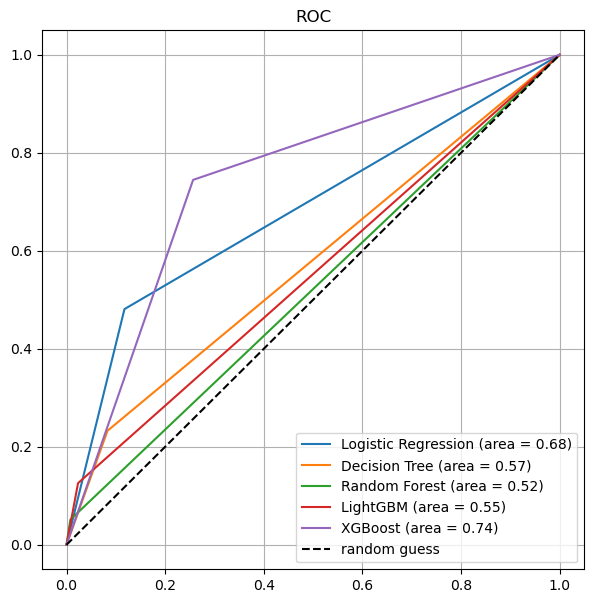

In [32]:
tmp = []

# LR
lr_clf = LogisticRegression(random_state=13, class_weight='balanced')
lr_clf.fit(X_train_svm, y_train_svm)
lr_pred_test = lr_clf.predict(X_test)

acc = accuracy_score(y_test, lr_pred_test)
pre = precision_score(y_test, lr_pred_test)
re = recall_score(y_test, lr_pred_test)
f1 = f1_score(y_test, lr_pred_test)
aucc = roc_auc_score(y_test, lr_pred_test)

# 결과 df로 저장
tmp.append(['lr_clf', acc, pre, re, f1, aucc])

# AUC
pred = lr_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr1, tpr1, thresholds = roc_curve(y_test, binary_pred)
roc_auc1 = auc(fpr1, tpr1)






####################################################################################################
# DT
dt_clf = DecisionTreeClassifier(random_state=13, class_weight='balanced')
dt_clf.fit(X_train_svm, y_train_svm)
dt_pred_test = dt_clf.predict(X_test)
# dt_pred_tr = dt_clf.predict(X_train_svm)

acc = accuracy_score(y_test, dt_pred_test)
pre = precision_score(y_test, dt_pred_test)
re = recall_score(y_test, dt_pred_test)
f1 = f1_score(y_test, dt_pred_test)
aucc = roc_auc_score(y_test, dt_pred_test)

tmp.append(['dt_clf', acc, pre, re, f1, aucc])

pred = dt_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr2, tpr2, thresholds = roc_curve(y_test, binary_pred)
roc_auc2 = auc(fpr2, tpr2)



###################################################################################################
# RF
rf_clf = RandomForestClassifier(random_state=13, class_weight='balanced')
rf_clf.fit(X_train_svm, y_train_svm)
rf_pred_test = rf_clf.predict(X_test)
# rf_pred_tr = rf_clf.predict(X_train_svm)

acc = accuracy_score(y_test, rf_pred_test)
pre = precision_score(y_test, rf_pred_test)
re = recall_score(y_test, rf_pred_test)
f1 = f1_score(y_test, rf_pred_test)
aucc = roc_auc_score(y_test, rf_pred_test)

tmp.append(['rf_clf', acc, pre, re, f1, aucc])

pred = rf_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr3, tpr3, thresholds = roc_curve(y_test, binary_pred)
roc_auc3 = auc(fpr3, tpr3)



#####################################################################################################
# LGBM
lgbm_clf = LGBMClassifier(random_state=13, class_weight='balanced')
lgbm_clf.fit(X_train_svm, y_train_svm)
lgbm_pred_test = lgbm_clf.predict(X_test)
# lgbm_pred_tr = lgbm_clf.predict(X_train_svm)

acc = accuracy_score(y_test, lgbm_pred_test)
pre = precision_score(y_test, lgbm_pred_test)
re = recall_score(y_test, lgbm_pred_test)
f1 = f1_score(y_test, lgbm_pred_test)
aucc = roc_auc_score(y_test, lgbm_pred_test)

tmp.append(['lgbm_clf', acc, pre, re, f1, aucc])

pred = lgbm_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr4, tpr4, thresholds = roc_curve(y_test, binary_pred)
roc_auc4 = auc(fpr4, tpr4)



########################################################################################################
# XGBoost
xgb_clf = XGBClassifier(random_sate=13, scale_pos_weight=10)

xgb_clf.fit(X_train_svm, y_train_svm)
xgb_pred_test = xgb_clf.predict(X_test)
# xgb_pred_tr = xgb_clf.predict(X_train_svm)


acc = accuracy_score(y_test, xgb_pred_test)
pre = precision_score(y_test, xgb_pred_test)
re = recall_score(y_test, xgb_pred_test)
f1 = f1_score(y_test, xgb_pred_test)
aucc = roc_auc_score(y_test, xgb_pred_test)

tmp.append(['xgb_clf', acc, pre, re, f1, aucc])

pred = xgb_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr5, tpr5, thresholds = roc_curve(y_test, binary_pred)
roc_auc5 = auc(fpr5, tpr5)





##########################################################################################################

col_names = ['model_names', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
df = pd.DataFrame(tmp, columns=col_names)
print(df)

plt.figure(figsize=(7, 7))

plt.plot(fpr1, tpr1, label='Logistic Regression (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Decision Tree (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Random Forest (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='LightGBM (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, label='XGBoost (area = %0.2f)' % roc_auc5)

plt.plot([0, 1], [0, 1], 'k--', label='random guess')
plt.title('ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

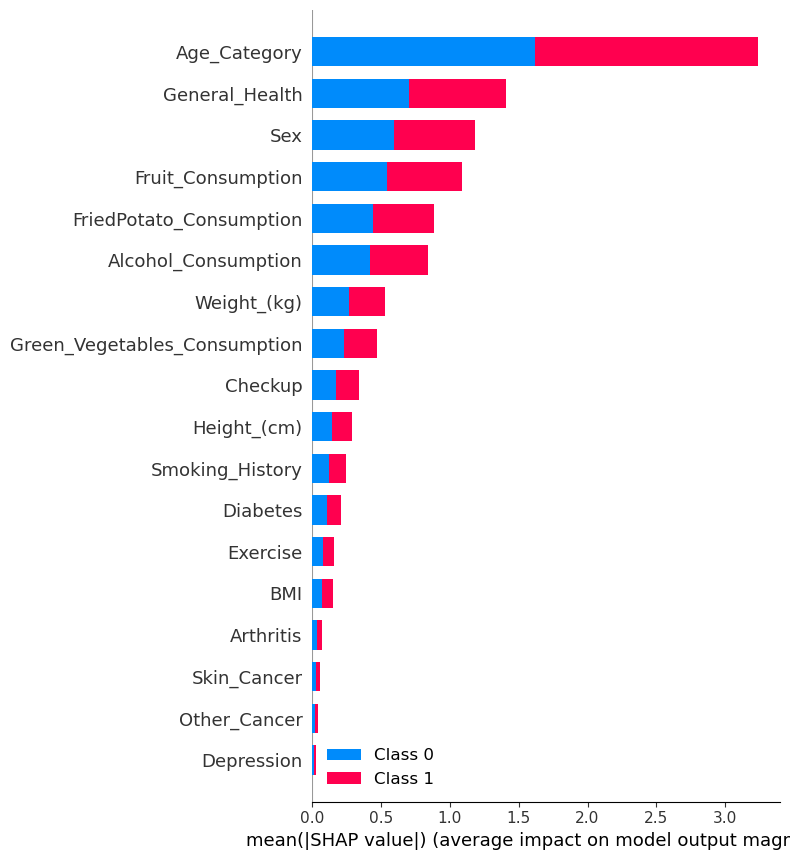

In [33]:
explainer = shap.Explainer(lgbm_clf)
shap_values = explainer.shap_values(X_test)

# 특정 데이터 포인트에 대한 SHAP 값을 확인
shap.summary_plot(shap_values, X_test)

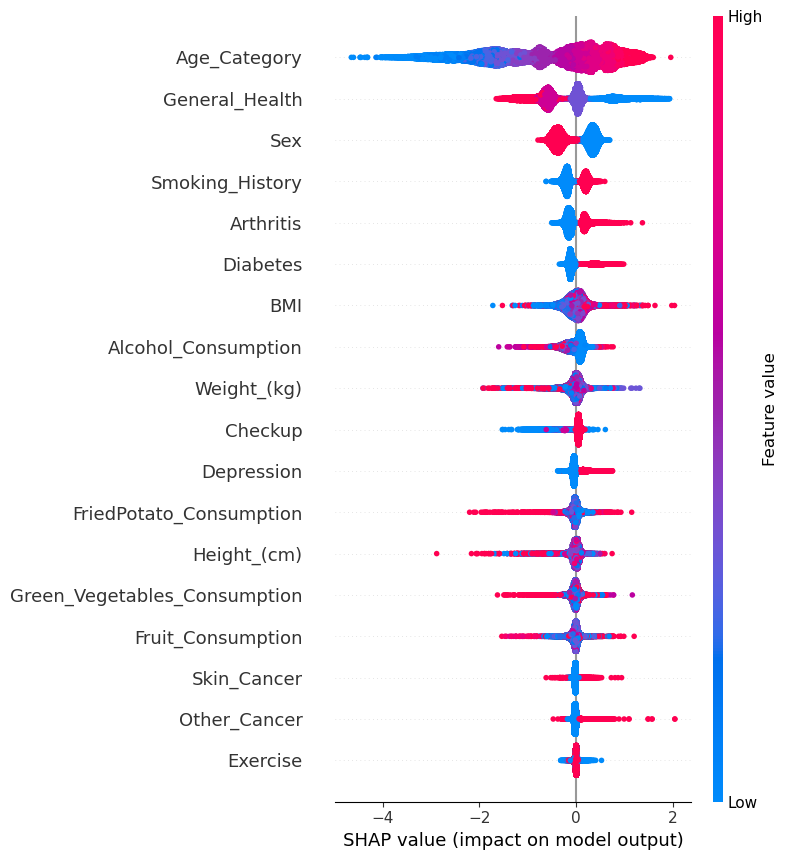

In [110]:
explainer = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

# 특정 데이터 포인트에 대한 SHAP 값을 확인
shap.summary_plot(shap_values, X_test)

----

### 6. 'Age_Category' 컬럼 제거
- 마찬가지로 해당 feature 제거로 성능을 향상시킬 수 있을까 확인

In [34]:
data.head(2)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,0,3.0,0,0,0,0,0,0,1,1,20,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,3,4.0,0,1,0,0,0,1,0,1,20,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0


In [35]:
data.drop('Age_Category', axis=1, inplace=True)

In [36]:
X = data.drop('Heart_Disease', axis = 1)
y = data['Heart_Disease']


# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


# svm SMOTE
svm_params = {'C': 0.001, 'max_iter': 1000}
svsmote = SVMSMOTE(random_state=13, out_step=0.7,  svm_estimator=SVC(**svm_params), n_jobs=-1)
X_train_svm, y_train_svm = svsmote.fit_resample(X_train, y_train)

model = SVC(**svm_params)
model.fit(X_train_svm, y_train_svm)

SVC(C=0.001, max_iter=1000)

[LightGBM] [Info] Number of positive: 99569, number of negative: 227106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 326675, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
  model_names  accuracy  precision    recall        f1   roc_auc
0      lr_clf  0.798546   0.182167  0.427513  0.255474  0.629347
1      dt_clf  0.859918   0.173711  0.195034  0.183756  0.556717
2      rf_clf  0.916255   0.305857  0.028234  0.051696  0.511299
3    lgbm_clf  0.889900   0.282969  0.235883  0.257290  0.591654
4     xgb_clf  0.735928   0.188621  0.686424  0.295925  0.713353


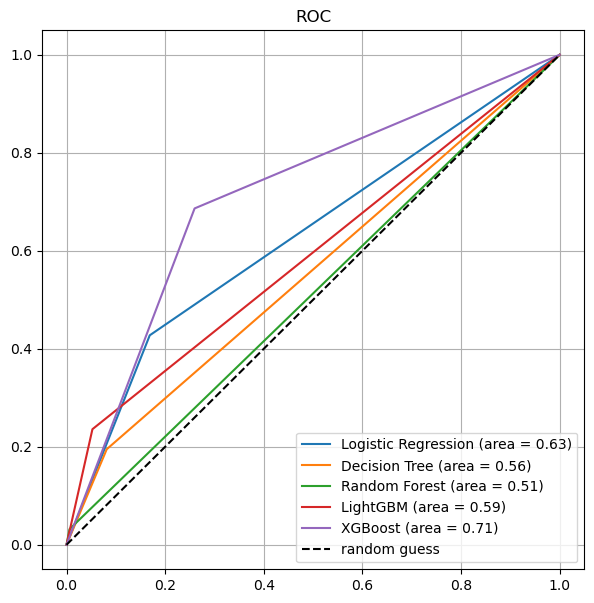

In [37]:
tmp = []

# LR
lr_clf = LogisticRegression(random_state=13, class_weight='balanced')
lr_clf.fit(X_train_svm, y_train_svm)
lr_pred_test = lr_clf.predict(X_test)

acc = accuracy_score(y_test, lr_pred_test)
pre = precision_score(y_test, lr_pred_test)
re = recall_score(y_test, lr_pred_test)
f1 = f1_score(y_test, lr_pred_test)
aucc = roc_auc_score(y_test, lr_pred_test)

# 결과 df로 저장
tmp.append(['lr_clf', acc, pre, re, f1, aucc])

# AUC
pred = lr_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr1, tpr1, thresholds = roc_curve(y_test, binary_pred)
roc_auc1 = auc(fpr1, tpr1)






####################################################################################################
# DT
dt_clf = DecisionTreeClassifier(random_state=13, class_weight='balanced')
dt_clf.fit(X_train_svm, y_train_svm)
dt_pred_test = dt_clf.predict(X_test)
# dt_pred_tr = dt_clf.predict(X_train_svm)

acc = accuracy_score(y_test, dt_pred_test)
pre = precision_score(y_test, dt_pred_test)
re = recall_score(y_test, dt_pred_test)
f1 = f1_score(y_test, dt_pred_test)
aucc = roc_auc_score(y_test, dt_pred_test)

tmp.append(['dt_clf', acc, pre, re, f1, aucc])

pred = dt_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr2, tpr2, thresholds = roc_curve(y_test, binary_pred)
roc_auc2 = auc(fpr2, tpr2)



###################################################################################################
# RF
rf_clf = RandomForestClassifier(random_state=13, class_weight='balanced')
rf_clf.fit(X_train_svm, y_train_svm)
rf_pred_test = rf_clf.predict(X_test)
# rf_pred_tr = rf_clf.predict(X_train_svm)

acc = accuracy_score(y_test, rf_pred_test)
pre = precision_score(y_test, rf_pred_test)
re = recall_score(y_test, rf_pred_test)
f1 = f1_score(y_test, rf_pred_test)
aucc = roc_auc_score(y_test, rf_pred_test)

tmp.append(['rf_clf', acc, pre, re, f1, aucc])

pred = rf_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr3, tpr3, thresholds = roc_curve(y_test, binary_pred)
roc_auc3 = auc(fpr3, tpr3)



#####################################################################################################
# LGBM
lgbm_clf = LGBMClassifier(random_state=13, class_weight='balanced')
lgbm_clf.fit(X_train_svm, y_train_svm)
lgbm_pred_test = lgbm_clf.predict(X_test)
# lgbm_pred_tr = lgbm_clf.predict(X_train_svm)

acc = accuracy_score(y_test, lgbm_pred_test)
pre = precision_score(y_test, lgbm_pred_test)
re = recall_score(y_test, lgbm_pred_test)
f1 = f1_score(y_test, lgbm_pred_test)
aucc = roc_auc_score(y_test, lgbm_pred_test)

tmp.append(['lgbm_clf', acc, pre, re, f1, aucc])

pred = lgbm_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr4, tpr4, thresholds = roc_curve(y_test, binary_pred)
roc_auc4 = auc(fpr4, tpr4)



########################################################################################################
# XGBoost
xgb_clf = XGBClassifier(random_sate=13, scale_pos_weight=10)

xgb_clf.fit(X_train_svm, y_train_svm)
xgb_pred_test = xgb_clf.predict(X_test)
# xgb_pred_tr = xgb_clf.predict(X_train_svm)


acc = accuracy_score(y_test, xgb_pred_test)
pre = precision_score(y_test, xgb_pred_test)
re = recall_score(y_test, xgb_pred_test)
f1 = f1_score(y_test, xgb_pred_test)
aucc = roc_auc_score(y_test, xgb_pred_test)

tmp.append(['xgb_clf', acc, pre, re, f1, aucc])

pred = xgb_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr5, tpr5, thresholds = roc_curve(y_test, binary_pred)
roc_auc5 = auc(fpr5, tpr5)





##########################################################################################################

col_names = ['model_names', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
df = pd.DataFrame(tmp, columns=col_names)
print(df)

plt.figure(figsize=(7, 7))

plt.plot(fpr1, tpr1, label='Logistic Regression (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Decision Tree (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Random Forest (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='LightGBM (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, label='XGBoost (area = %0.2f)' % roc_auc5)

plt.plot([0, 1], [0, 1], 'k--', label='random guess')
plt.title('ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

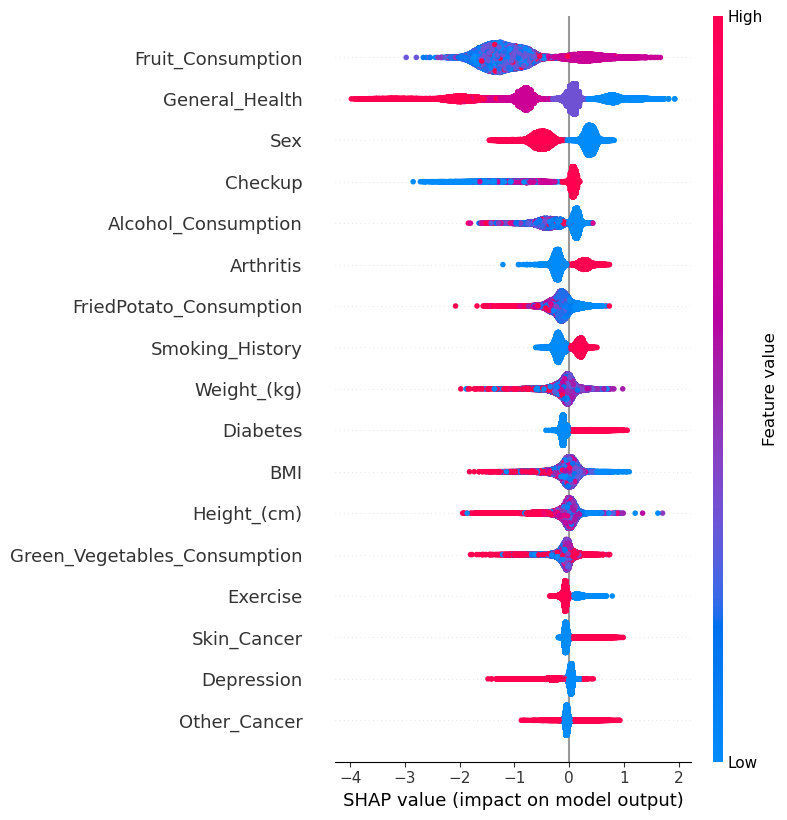

In [38]:
explainer = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

# 특정 데이터 포인트에 대한 SHAP 값을 확인
shap.summary_plot(shap_values, X_test)

---

### 7. 'Fruit_Consumption', 'General_Health' 제거
- 해당 feature까지 제거했을 경우

In [39]:
data.head(2)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,0,3.0,0,0,0,0,0,0,1,1,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,3,4.0,0,1,0,0,0,1,0,1,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0


In [40]:
data.drop(['Fruit_Consumption','General_Health'], axis=1, inplace=True)

In [41]:
X = data.drop('Heart_Disease', axis = 1)
y = data['Heart_Disease']


# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)


# svm SMOTE
svm_params = {'C': 0.001, 'max_iter': 1000}
svsmote = SVMSMOTE(random_state=13, out_step=0.7,  svm_estimator=SVC(**svm_params), n_jobs=-1)
X_train_svm, y_train_svm = svsmote.fit_resample(X_train, y_train)

model = SVC(**svm_params)
model.fit(X_train_svm, y_train_svm)

SVC(C=0.001, max_iter=1000)

[LightGBM] [Info] Number of positive: 99569, number of negative: 227106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1779
[LightGBM] [Info] Number of data points in the train set: 326675, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
  model_names  accuracy  precision    recall        f1   roc_auc
0      lr_clf  0.707225   0.143511  0.527633  0.225648  0.625327
1      dt_clf  0.856195   0.156631  0.177613  0.166463  0.546747
2      rf_clf  0.915122   0.223947  0.020224  0.037098  0.507030
3    lgbm_clf  0.857943   0.200159  0.252703  0.223383  0.581941
4     xgb_clf  0.664179   0.153298  0.697237  0.251335  0.679254


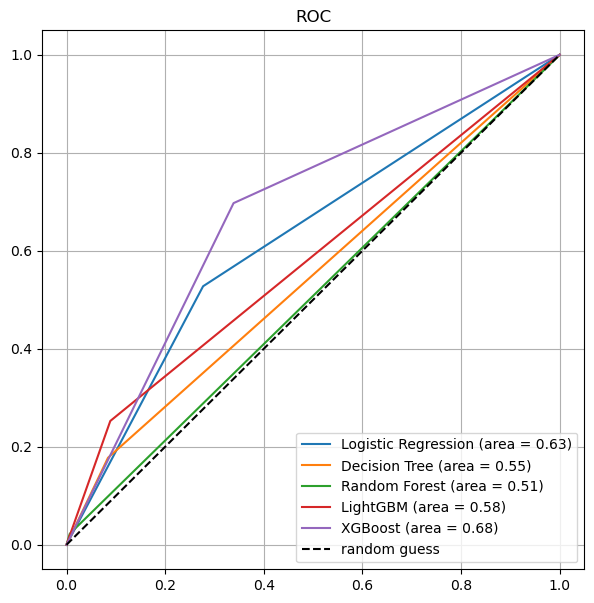

In [42]:
tmp = []

# LR
lr_clf = LogisticRegression(random_state=13, class_weight='balanced')
lr_clf.fit(X_train_svm, y_train_svm)
lr_pred_test = lr_clf.predict(X_test)

acc = accuracy_score(y_test, lr_pred_test)
pre = precision_score(y_test, lr_pred_test)
re = recall_score(y_test, lr_pred_test)
f1 = f1_score(y_test, lr_pred_test)
aucc = roc_auc_score(y_test, lr_pred_test)

# 결과 df로 저장
tmp.append(['lr_clf', acc, pre, re, f1, aucc])

# AUC
pred = lr_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr1, tpr1, thresholds = roc_curve(y_test, binary_pred)
roc_auc1 = auc(fpr1, tpr1)






####################################################################################################
# DT
dt_clf = DecisionTreeClassifier(random_state=13, class_weight='balanced')
dt_clf.fit(X_train_svm, y_train_svm)
dt_pred_test = dt_clf.predict(X_test)
# dt_pred_tr = dt_clf.predict(X_train_svm)

acc = accuracy_score(y_test, dt_pred_test)
pre = precision_score(y_test, dt_pred_test)
re = recall_score(y_test, dt_pred_test)
f1 = f1_score(y_test, dt_pred_test)
aucc = roc_auc_score(y_test, dt_pred_test)

tmp.append(['dt_clf', acc, pre, re, f1, aucc])

pred = dt_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr2, tpr2, thresholds = roc_curve(y_test, binary_pred)
roc_auc2 = auc(fpr2, tpr2)



###################################################################################################
# RF
rf_clf = RandomForestClassifier(random_state=13, class_weight='balanced')
rf_clf.fit(X_train_svm, y_train_svm)
rf_pred_test = rf_clf.predict(X_test)
# rf_pred_tr = rf_clf.predict(X_train_svm)

acc = accuracy_score(y_test, rf_pred_test)
pre = precision_score(y_test, rf_pred_test)
re = recall_score(y_test, rf_pred_test)
f1 = f1_score(y_test, rf_pred_test)
aucc = roc_auc_score(y_test, rf_pred_test)

tmp.append(['rf_clf', acc, pre, re, f1, aucc])

pred = rf_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr3, tpr3, thresholds = roc_curve(y_test, binary_pred)
roc_auc3 = auc(fpr3, tpr3)



#####################################################################################################
# LGBM
lgbm_clf = LGBMClassifier(random_state=13, class_weight='balanced')
lgbm_clf.fit(X_train_svm, y_train_svm)
lgbm_pred_test = lgbm_clf.predict(X_test)
# lgbm_pred_tr = lgbm_clf.predict(X_train_svm)

acc = accuracy_score(y_test, lgbm_pred_test)
pre = precision_score(y_test, lgbm_pred_test)
re = recall_score(y_test, lgbm_pred_test)
f1 = f1_score(y_test, lgbm_pred_test)
aucc = roc_auc_score(y_test, lgbm_pred_test)

tmp.append(['lgbm_clf', acc, pre, re, f1, aucc])

pred = lgbm_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr4, tpr4, thresholds = roc_curve(y_test, binary_pred)
roc_auc4 = auc(fpr4, tpr4)



########################################################################################################
# XGBoost
xgb_clf = XGBClassifier(random_sate=13, scale_pos_weight=10)

xgb_clf.fit(X_train_svm, y_train_svm)
xgb_pred_test = xgb_clf.predict(X_test)
# xgb_pred_tr = xgb_clf.predict(X_train_svm)


acc = accuracy_score(y_test, xgb_pred_test)
pre = precision_score(y_test, xgb_pred_test)
re = recall_score(y_test, xgb_pred_test)
f1 = f1_score(y_test, xgb_pred_test)
aucc = roc_auc_score(y_test, xgb_pred_test)

tmp.append(['xgb_clf', acc, pre, re, f1, aucc])

pred = xgb_clf.predict_proba(X_test)[:, 1]
binary_pred = (pred>=0.5).astype(int)
fpr5, tpr5, thresholds = roc_curve(y_test, binary_pred)
roc_auc5 = auc(fpr5, tpr5)





##########################################################################################################

col_names = ['model_names', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
df = pd.DataFrame(tmp, columns=col_names)
print(df)

plt.figure(figsize=(7, 7))

plt.plot(fpr1, tpr1, label='Logistic Regression (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Decision Tree (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Random Forest (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='LightGBM (area = %0.2f)' % roc_auc4)
plt.plot(fpr5, tpr5, label='XGBoost (area = %0.2f)' % roc_auc5)

plt.plot([0, 1], [0, 1], 'k--', label='random guess')
plt.title('ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

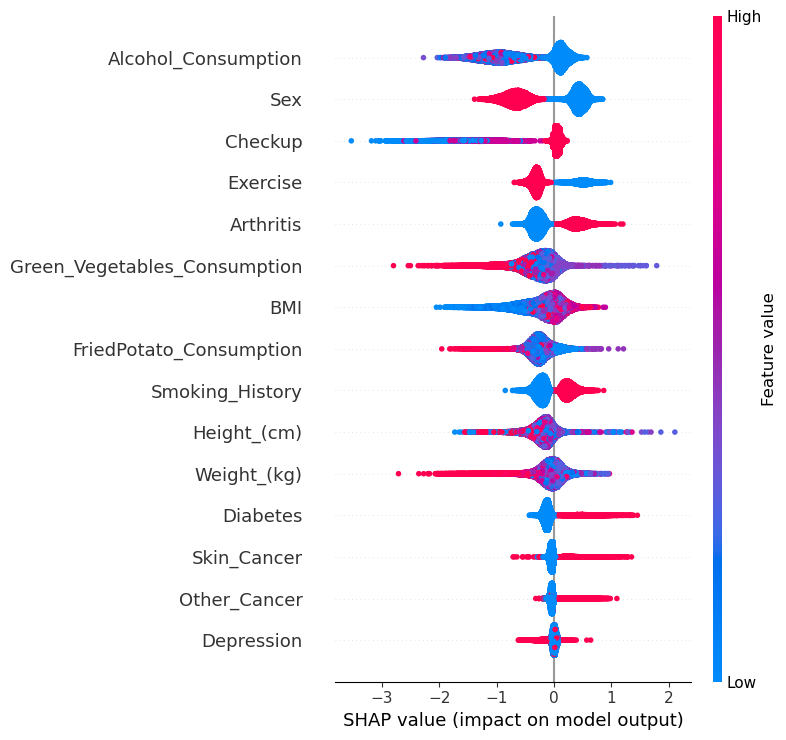

In [43]:
explainer = shap.Explainer(xgb_clf)
shap_values = explainer.shap_values(X_test)

# 특정 데이터 포인트에 대한 SHAP 값을 확인
shap.summary_plot(shap_values, X_test)

---

--> shap의 summary plot의 파란 영역에 속하는 데이터를 찾지 못해서 대안으로 해당 feature들을 삭제해봤으나 오히려 성능을 떨어뜨릴뿐더러, 다른 feature들의 부정적인 영향력을 키움...